Per valutare un **Par Asset Swap (PAS)**, dobbiamo calcolare il valore attuale netto (NPV) di due gambe:

1. **Bond Leg**: Il valore del titolo (spesso un corporate bond o un titolo di stato) scontato sulla curva di mercato.
2. **Swap Leg**: Uno scambio di flussi dove una parte paga le cedole del bond e riceve un tasso variabile (Libor/Euribor) + uno **spread** (l'Asset Swap Spread).

In un *Par* Asset Swap, l'investitore paga il valore **Par (100)** del bond all'inizio, indipendentemente dal prezzo di mercato del titolo.

Ecco una classe Python essenziale che implementa questa logica.

---

### Implementazione: Classe `ParAssetSwap`

In [ ]:
from itertools import pairwise

from finmarkets import generate_dates, GlobalConst

class AssetSwap:
    def __init__(self, bond_price, nominal, coupon_rate, maturity, asw_spread, frequency="1y"):
        """
        A class representing Par Asset Swaps

        Attributes:
        -----------
        :param bond_price: float
            Bond current market value (e.g. 98.5)
        :param coupon_rate: float
            Bond annual coupon
        :param maturity: str
            Maturity of the contract        
        :param asw_spread: float
            Asset swap spread
        :param frequency: str
            Coupon frequency
        """
        self.coupon_rate = coupon_rate
        self.bond_price = bond_price
        self.nominal = nominal
        self.maturity = maturity
        self.s = asw_spread        
        start_date = GlobalConst.OBSERVATION_DATE
        self.payment_dates = generate_dates(start_date, maturity, frequency)

    def npv_fixed_leg(self, dc):
        """
        Evaluate the current bond value
    
        Params:
        -------
        dc: DiscountCurve
            discount curve to be used in the calculation
        """
        npv = 0
        for d0, d1 in pairwise(self.payment_dates):
            tau = (d1 - d0).days/365
            npv += self.coupon_rate*tau*dc.df(d1)
        npv += dc.df(d1)

        return self.nominal*npv

    def npv_floating_leg(self, dc, fc, s=None):
        """
        Evaluate the swap value, by default receive variable+spread, pay bond coupon
        Usually it should compensate the difference between Par and current bond price

        Params:
        -------
        dc: DiscountCurve
            discount curve to be used in the calculation
        s: float
            custom spread, set only when determing the asset swap spread
        """
        spread = s if s is not None else self.s
        npv = 0
        for d0, d1 in pairwise(self.payment_dates):
            tau = (d1 - d0).days/365
            npv += (fc.forward_rate(d0, d1) + spread) * dc.df(d1) * tau        
        npv += dc.df(d1)
        return self.nominal*npv
    
    def par_par_adjustment(self):
        return self.nominal * (100 - self.bond_price)/100
    
    def npv(self, dc, fc, s=None):
        """
        Evaluate the asset swap
        
        Params:
        -------
        dc: DiscountCurve
            discount curve to be used in the calculation
        """
        return self.npv_fixed_leg(dc) - self.npv_floating_leg(dc, fc, s) + self.par_par_adjustment()
        
    def solve_spread(self, dc, fc):
        from scipy.optimize import newton
        
        return newton(lambda s: self.npv(dc, fc, s), x0=0.1)

In [187]:
import numpy as np

from finmarkets import DiscountCurve, GlobalConst, generate_dates, TermStructure

start_date = GlobalConst.OBSERVATION_DATE
pillars = generate_dates(start_date, "10y", "1y")
df = [np.exp(-0.03*t) for t in range(11)]
dc = DiscountCurve(pillars, df)

fc = TermStructure(pillars, [0.03 for i in range(11)])


# print(f"NPV Bond Leg: {asw.npv_fixed_leg(dc):.4f}")
# print(f"NPV float Leg: {asw.npv_floating_leg(dc, fc):.4f}")
# print(f"NPV Asset Swap: {asw.npv(dc, fc):.4f}")

spreads = []
for P in np.arange(90, 110, 0.1):
    asw = AssetSwap(start_date, bond_price=P, nominal=100, coupon_rate=0.04, maturity="5y", asw_spread=0.005)
    spreads.append(asw.solve_spread(dc, fc)*10000)

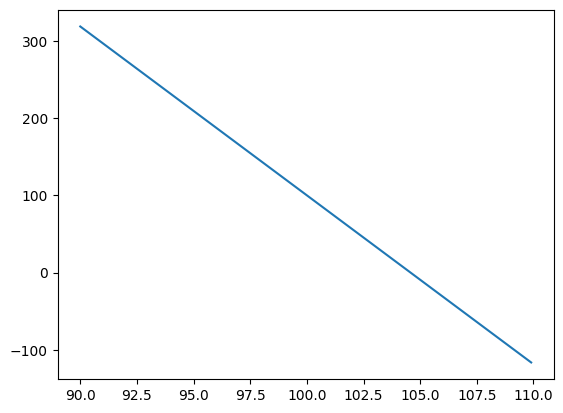

In [188]:
from matplotlib import pyplot as plt

plt.plot(np.arange(90, 110, 0.1), spreads)
plt.show()

Ottima domanda. A prima vista sembra un errore, ma in realtà dietro c'è un trucco matematico fondamentale usato nel pricing dei derivati: la teoria della replica (o model-independent pricing della gamba floating).

Il motivo per cui il tasso floating (es. EURIBOR) non compare esplicitamente nella funzione npv_swap_leg è che, in assenza di rischio di credito sulla controparte dello swap, una gamba che paga il tasso floating flat vale sempre esattamente Par (100%) alle date di reset.

Ecco la spiegazione dettagliata:
1. La scomposizione della gamba Floating

In un Par Asset Swap, l'investitore riceve dalla controparte dello swap:
Flusso Floating=Libor/Euribor+ASW Spread

Matematicamente, il valore attuale (NPV) di questa gamba è la somma di due componenti:

    Il valore attuale dei tassi floating (Euribor).

    Il valore attuale dello spread costante (s).

2. Il "miracolo" del Floating Rate Note (FRN)

Secondo la teoria finanziaria, un titolo che paga esattamente il tasso interbancario di mercato (senza spread) e rimborsa il capitale alla fine, ha un valore attuale oggi pari al suo valore nominale (Par), indipendentemente da quali saranno i tassi futuri.

Quindi, se consideriamo il nominale dello swap come 100:

    Il valore attuale della gamba floating (solo tasso L) + il valore attuale del rimborso del capitale alla fine è uguale a 100.

3. Cosa sta calcolando il codice?

Il codice che hai postato calcola l'NPV totale dal punto di vista dell'investitore. Vediamo come si semplificano i flussi di cassa:

    Gamba Bond: Ricevi cedole fisse + Capitale finale. (Calcolato in npv_bond_leg)

    Gamba Swap: * Paghi le cedole fisse del bond alla controparte.

        Ricevi il tasso floating (L).

        Ricevi lo spread (s).

        Paghi/Ricevi la differenza iniziale tra prezzo del bond e Par (P−100).

4. La semplificazione algebrica

Se scrivi l'equazione dell'NPV totale dello swap (dove il floating "puro" vale Par), noterai che il tasso floating L scompare perché viene sostituito dalla sua valutazione implicita di mercato.

Nella funzione npv_swap_leg che hai postato:
Python

In [ ]:
Certamente. Per proiettare i tassi futuri (e quindi non basarsi sulla semplificazione teorica che la gamba floating valga sempre Par), dobbiamo introdurre una Forward Curve.

In questo scenario, per ogni periodo i, calcoleremo il tasso forward Fi​ implicito nella curva per quel segmento temporale.
La logica del calcolo "esplicito"

L'NPV della gamba swap sarà composto da tre elementi:

    Gamba Variabile: ∑(Fi​+s)⋅τi​⋅dfi​

    Scambio di Capitale (Netto): La differenza tra il prezzo pagato per il bond e il valore nominale.

    Gamba Fissa (Pagata dallo swap): −∑Cbond​⋅τi​⋅dfi​ (che nel tuo codice è già gestita per differenza o separatamente).

Ecco come potresti modificare o estendere la classe per includere una ForwardCurve (fc):

A Par Asset Swap (PAS) is defined as a synthetic structure that transforms the risk profile of a specific bond—typically a fixed-rate credit instrument—into a floating-rate note (FRN) that pays a spread over a benchmark (like EURIBOR or SOFR).

**The logic centers on isolating the credit risk from the interest rate risk**. In a PAS, the investor purchases a risky bond at its market price $P$ and simultaneously enters into a payer interest rate swap (IRS) with a swap counterparty. Unlike a standard IRS, the notionals are exchanged at inception if the bond is not trading at par. 

The "Par" designation refers to the fact that the swap is structured such that the initial net investment equals the bond’s par value, and the floating leg coupon is adjusted by a constant Asset Swap Spread (ASWS) to equate the present values of the two legs.

#### The Structural Logic and Cash Flows

At inception ($t=0$), if the bond price $P$ is below par (100), the investor pays $P$ for the bond and pays the "upfront" difference ($100−P$) to the swap counterparty. In return, at maturity ($T$), the investor receives par from the bond and the swap counterparty ensures the final exchange returns the full notionals.

The periodic cash flow identity for the investor is:
    * receive: fixed coupon from the bond ($C_{bond}​$).
    * pay: fixed coupon to the swap counterparty ($C_{swap}$​).
    * receive: floating rate ($L$) plus the Asset Swap Spread ($A$).

The net periodic cash flow is:
$$
\text{Net CF} = C_{bond}$ - C_{swap} + (L + A)
$$

#### Mathematical Formulation

To solve for the Asset Swap Spread ($A$), we set the initial price of the bond equal to the present value of the swap cash flows. Let $P$ be the clean price of the bond plus accrued interest, $v(t_i​)$ be the discount factor for time $t_i$​, and $L_i$​ be the floating rate.

The valuation at $t=0$ for a par asset swap is:
$$
P + \sum_{i=1}^{N}(C_{swap}​−C_{bond}​)\cdot v(t_i)=100
$$

However, the more common way to express the spread $A$ (assuming the swap is struck at the market swap rate where the fixed leg equals the floating leg) is:
$$
A=\frac{(100-P)+\sum_{i=1}^{N}(C_{bond}-S)\cdot v(t_i)}{\sum_{i=1}^{N}v(t_i)}
$$
where: $P$ is the current market price of the bond, $S$ is the par swap rate for the same maturity and the denominator is the annuity of the bond's payment dates.

#### Primary Use Cases
    * Credit Relative Value Analysis: investors use the ASW spread to compare the credit risk of bonds with different coupons or maturities. Since the interest rate risk is hedged out, the ASW represents the "pure" premium for the issuer's default and liquidity risk.
    * Yield Enhancement: if an investor believes the market has over-discounted the credit risk of a specific corporate issuer relative to the swap curve, they can lock in a high floating-rate spread.
    * Hedged Portfolios: banks and insurance companies use ASW to match floating-rate liabilities with fixed-rate assets without being exposed to duration risk (interest rate sensitivity).
    * Arbitrage: if a bond’s ASW is significantly higher than the premium of a Credit Default Swap (CDS) for the same issuer, a "basis trade" may be executed to capture the discrepancy.

Comparing an Asset Swap Spread (ASW) and a Credit Default Swap (CDS) spread is a fundamental exercise in relative value analysis. In a world without market frictions, they should be equal because they both represent the cost of credit risk.

In reality, the difference between them is known as the Basis (specifically, the CDS-Bond Basis).
1. The Relationship: CDS-Bond Basis

The "Basis" is defined as:
Basis=CDS Spread−ASW Spread

    Negative Basis (CDS < ASW): The bond is "cheap" relative to the CDS. It pays more spread than it costs to insure it. This is a classic arbitrage opportunity (buy the bond, buy the CDS protection, and pocket the difference).

Positive Basis (CDS > ASW): The bond is "expensive" relative to the CDS.

2. Why they aren't the same: Key Drivers

To compare them fairly, you must account for several structural differences:
A. The "Par" Problem

The Par-Par Asset Swap (the one we solved earlier) assumes the investor pays 100 today. If the bond is trading at 95, the ASW spread includes a "pull-to-par" effect. The CDS, however, always references the par value of the credit. This creates a mathematical mismatch if the bond price is far from 100.
B. Funding and Cash vs. Synthetic

    Bond (Cash): Buying a bond requires cash. If you borrow money to buy it (Repo), you must pay the Repo rate. The ASW spread is effectively a spread over Libor/Euribor.

CDS (Synthetic): A CDS is an unfunded derivative. You don't need the full principal upfront. Therefore, the CDS spread is purely a "risk premium," while the ASW spread is a "risk premium + funding cost."

C. Counterparty Risk

When you buy a bond and an asset swap, you have credit exposure to the Bond Issuer and the Swap Counterparty. In a CDS, you only have exposure to the Protection Seller.

D. Accrued Interest and Default

    In a bond, if the issuer defaults, you lose the accrued interest.

    In a standard CDS, the protection seller usually pays the "accrued" to the buyer upon a credit event.

3. How to perform the comparison (Practical Steps)

To get a "clean" comparison, you shouldn't just look at the raw ASW spread. You should follow these steps:

    Match Maturities: Ensure the CDS tenor (e.g., 5Y) matches the bond's remaining maturity exactly. Even a 6-month difference can skew the result due to the credit curve's slope.

    Use the Z-Spread for High Accuracy: While ASW is standard, the Z-Spread (the constant spread over the risk-free curve that recovers the bond price) is often a "purer" measure of credit risk to compare against CDS, as it avoids some of the swap-specific artifacts.

    Check the "Jump to Default" (JTD): If a bond is trading at 60 (distressed), the ASW spread will be astronomical. However, the CDS is capped by the fact that it only pays 100−Recovery. The comparison breaks down when a bond is deep in the discount.

4. The "Arbitrage" Trade

If you find a Negative Basis (ASW = 150 bps, CDS = 100 bps):

    Buy the Bond (Receive 150 bps over Libor).

    Buy CDS Protection (Pay 100 bps).

    Result: You have hedged the credit risk and you are earning a "risk-free" 50 bps (minus funding costs).    